In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from heamy.estimator import Regressor
# убрал import getargspec в lib/heamy/estimator.py - иначе estimator не импортировался 
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.neural_network import MLPRegressor

In [3]:
data = pd.read_csv('Mobile Price Prediction.csv', sep=",")

In [4]:
data.shape

(292, 6)

In [5]:
data.head

<bound method NDFrame.head of      Screen Size  RAM  Storage  Battery Capacity  Camera Quality  Price
0            6.2    4       64              4000              48    500
1            6.1    3      128              3110              12    800
2            6.5    6      256              4500              64    600
3            6.7    8      128              4300              48    700
4            6.4    6      128              4200              40    550
..           ...  ...      ...               ...             ...    ...
287          6.0    6       64              3700              12    750
288          6.3    4      128              4025              32    450
289          6.6    8      256              5000              48    700
290          6.5    6      128              4500              64    550
291          6.1    4       64              3000              16    400

[292 rows x 6 columns]>

In [6]:
data.dtypes

Screen Size         float64
RAM                   int64
Storage               int64
Battery Capacity      int64
Camera Quality        int64
Price                 int64
dtype: object

# 2. Проверка на пропуски

In [7]:
data.isnull().sum()

Screen Size         0
RAM                 0
Storage             0
Battery Capacity    0
Camera Quality      0
Price               0
dtype: int64

# 3. Разделение выборки на обучающую и тестовую

In [8]:
ins_data = data.drop(columns='Price')
ins_X, ins_y = ins_data, data[['Price']].values
ins_X_train, ins_X_test, ins_y_train, ins_y_test = train_test_split(
    ins_X, ins_y, test_size=0.2, random_state=1)

# 4.1 Модель группы стекинга

In [9]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(ins_X_train, ins_y_train)
    y_pred = model.predict(ins_X_test)
    result = mean_absolute_error(ins_y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [38]:
# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print()

LinearRegression()
MAE=91.77213251714615

DecisionTreeRegressor()
MAE=5.932203389830509

RandomForestRegressor(n_estimators=50)
MAE=10.932203389830509



c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [36]:
# Используем библиотеку heamy
# набор данных

dataset = Dataset(ins_X_train, ins_y_train, ins_X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression,name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [12]:
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)


Metric: mean_absolute_error
Folds accuracy: [10.099482322212891, 11.079378673785781, 19.34684684227087, 30.209752520471028, 9.873620825195745, 21.754293964323068, 12.3393354483684, 24.53804227710834, 8.258690680427428, 22.413285340984103]
Mean accuracy: 16.991272889514768
Standard Deviation: 7.213334906396753
Variance: 52.03220047184185


In [37]:
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1474: DataConversionW

Metric: mean_absolute_error
Folds accuracy: [13.589403717629898, 11.54047104518372, 11.851948191333255, 30.949803198842545, 8.597168913783637, 14.7265943482436, 12.32657560629455, 25.638230662453452, 11.743345265394503, 15.05109971590865]
Mean accuracy: 15.601464066506784
Standard Deviation: 6.683154509112947
Variance: 44.66455419267672


In [39]:
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: дерево

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=DecisionTreeRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [16.666666666666668, 22.916666666666668, 12.5, 32.608695652173914, 4.3478260869565215, 17.391304347826086, 8.695652173913043, 19.565217391304348, 17.391304347826086, 17.391304347826086]
Mean accuracy: 16.947463768115945
Standard Deviation: 7.314719612167022
Variance: 53.50512300462087


In [41]:
# Первый уровень - три модели: дерево, случайный лес и линейная регрессия
# Второй уровень: дерево

pipeline = ModelsPipeline(model_tree, model_rf, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=DecisionTreeRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [8.333333333333334, 6.25, 0.0, 28.26086956521739, 4.3478260869565215, 13.043478260869565, 15.217391304347826, 21.73913043478261, 17.391304347826086, 10.869565217391305]
Mean accuracy: 12.545289855072465
Standard Deviation: 8.044503337540489
Variance: 64.71403394770006


In [42]:
# Результаты
array_labels = ['LR', 'TREE', 'RF', 'TREE+LR=>LR', 'TREE+LR=>TREE', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>TREE']
array_mae = [19.645947869043603, 
             5.932203389830509, 
             10.932203389830509, 
             16.991272889514768, 
             16.947463768115945, 
             15.601464066506784, 
             12.545289855072465]

In [43]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()  

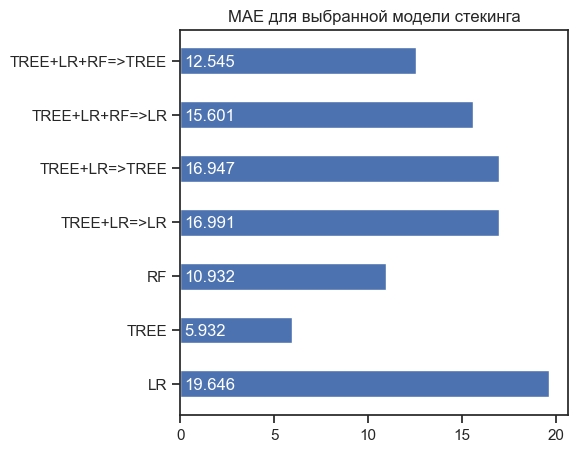

In [44]:
# Визуализация результатов
vis_models_quality(array_mae, array_labels, 'MAE для выбранной модели стекинга')

# 4.2 Модель многослойного перспектрона

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Масштабируем признаки обучающего набора и применяем трансформацию к тестовому набору
ins_X_train_scaled = scaler.fit_transform(ins_X_train)
ins_X_test_scaled = scaler.fit_transform(ins_X_test)

In [17]:
from time import time

i = 0
df = pd.DataFrame(columns = ['alpha','max_iter','train_mae','test_mae','train_time'])
for a in [0.00001,0.0001,0.001,0.01, 0.1, 1, 10]:
    for mi in [10, 100, 1000, 10000]:
        st = time()
        mlp = MLPRegressor(alpha=a, max_iter=mi, random_state=1)
        mlp.fit(ins_X_train_scaled, ins_y_train)
        end = time() - st
        
        mae_tr = mean_absolute_error(ins_y_train, mlp.predict(ins_X_train_scaled))
        mae = mean_absolute_error(ins_y_test, mlp.predict(ins_X_test_scaled))
        df.loc[i] = [a,mi,mae_tr,mae,end]
        i=i+1

c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_p

In [18]:
df.sort_values(by='test_mae').head(3)
# лучшие параметры у модели 19: alpha = 0.1, max_iter = 10000

,alpha,max_iter,train_mae,test_mae,train_time
19,0.10000,10000.0,44.598683,66.395082,5.492069
3,0.00001,10000.0,48.785653,68.379520,6.076551
7,0.00010,10000.0,48.781782,68.387106,6.130107


In [19]:
mae = []
mae_tr = []
timelog = []
for l in [1,2,5,10,20,50,100,200,500,1000]:
    t = time()
    mlp = MLPRegressor(alpha=0.1, max_iter=10000, hidden_layer_sizes=(l,))
    mlp.fit(ins_X_train_scaled, ins_y_train)
    endt = time() - t
        
    m_tr = mean_absolute_error(ins_y_train, mlp.predict(ins_X_train_scaled))
    m = mean_absolute_error(ins_y_test, mlp.predict(ins_X_test_scaled))

    mae_tr.append(m_tr)
    mae.append(m)
    timelog.append(endt)

c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilaye

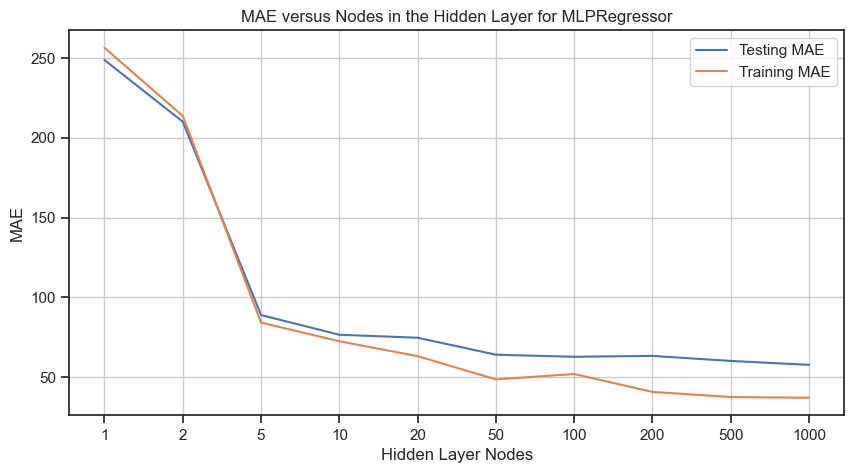

In [20]:
l = [1,2,5,10,20,50,100,200,500,1000]
N = len(l)
l2 = np.arange(N)
plt.subplots(figsize=(10, 5))
plt.plot(l2, mae, label="Testing MAE")
plt.plot(l2, mae_tr, label="Training MAE")
plt.xticks(l2,l)
plt.grid(True)
plt.xlabel("Hidden Layer Nodes")
plt.ylabel("MAE")
plt.legend()
plt.title('MAE versus Nodes in the Hidden Layer for MLPRegressor', fontsize=12)
plt.show()

In [21]:
mae = []
mae_tr = []
timelog = []
for l in [0.0001, 0.001, 0.01, 0.1, 1]:
    t = time()
    mlp = MLPRegressor(alpha=0.1, max_iter=10000, hidden_layer_sizes=(1000,500), learning_rate_init=l)
    mlp.fit(ins_X_train_scaled, ins_y_train)
    endt = time() - t
        
    m_tr = mean_absolute_error(ins_y_train, mlp.predict(ins_X_train_scaled))
    m = mean_absolute_error(ins_y_test, mlp.predict(ins_X_test_scaled))

    mae_tr.append(m_tr)
    mae.append(m)
    timelog.append(endt)

c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yulia\AppData\Local\Programs\Python\Python3

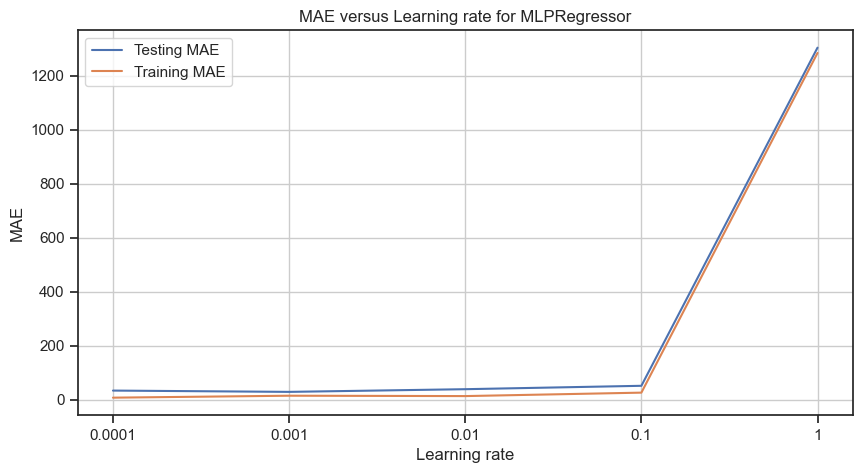

In [22]:
l = [0.0001, 0.001, 0.01, 0.1, 1]
N = len(l)
l2 = np.arange(N)
plt.subplots(figsize=(10, 5))
plt.plot(l2, mae, label="Testing MAE")
plt.plot(l2, mae_tr, label="Training MAE")
plt.xticks(l2,l)
plt.grid(True)
plt.xlabel("Learning rate")
plt.ylabel("MAE")
plt.legend()
plt.title('MAE versus Learning rate for MLPRegressor', fontsize=12)
plt.show()

In [23]:
mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), max_iter=10000, alpha=0.1,
                   solver='adam', verbose=10, random_state=1, learning_rate_init=0.001)
# вместо sgd использовал adam - так меньше loss

mlp.fit(ins_X_train_scaled, ins_y_train)

c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 204434.15083671
Iteration 2, loss = 203587.73005234
Iteration 3, loss = 202708.55171288
Iteration 4, loss = 201702.70549348
Iteration 5, loss = 200480.13033299
Iteration 6, loss = 199031.81753998
Iteration 7, loss = 197322.61110278
Iteration 8, loss = 195336.24980220
Iteration 9, loss = 193028.48457161
Iteration 10, loss = 190364.19311812
Iteration 11, loss = 187301.67810375
Iteration 12, loss = 183798.61161643
Iteration 13, loss = 179845.58572269
Iteration 14, loss = 175359.10704415
Iteration 15, loss = 170371.90285767
Iteration 16, loss = 164805.02148264
Iteration 17, loss = 158659.82927263
Iteration 18, loss = 151923.26699656
Iteration 19, loss = 144550.75259703
Iteration 20, loss = 136631.82318289
Iteration 21, loss = 128201.25653878
Iteration 22, loss = 119220.17775409
Iteration 23, loss = 109763.68897935
Iteration 24, loss = 100148.83179483
Iteration 25, loss = 90198.58328084
Iteration 26, loss = 80359.73616784
Iteration 27, loss = 70627.40572058
Iteration 28,

MLPRegressor(alpha=0.1, hidden_layer_sizes=(1000, 500), max_iter=10000,
             random_state=1, verbose=10)

# 4.3 МГУА

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(y_test, y_pred, squared=False):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    crit_name = "MSE" if squared else "RMSE"
    print(f"{crit_name}: {mean_squared_error(y_test, y_pred, squared=squared)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

def show_metric_for(y_pred, n=365):
  print_metrics(scaler.inverse_transform(ins_y_test.reshape(-1, 1)).flatten()[:n], y_pred[:n])

In [26]:
import gmdh
gmdh_combi = gmdh.Combi()
gmdh_combi.fit(ins_X_train_scaled, ins_y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, 
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))

LEVEL 1  [=========================] 100% :00s] (5 combinations) error=695146.7162                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [27]:
gmdh_mia = gmdh.Mia()
gmdh_mia.fit(ins_X_train_scaled, ins_y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, k_best=9, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.SYM_REGULARITY), 
                     polynomial_type=gmdh.PolynomialType.LINEAR)

LEVEL 1  [=========================] 100% :00s] (10 combinations) error=3.67867e+06                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [28]:
pred_mia = gmdh_mia.predict(ins_X_test_scaled)
print_metrics(ins_y_test, pred_mia)

R^2: 0.13334188124042634
RMSE: 116.98091376329361
MAE: 89.65482934967766


c:\Users\yulia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(8, 8)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

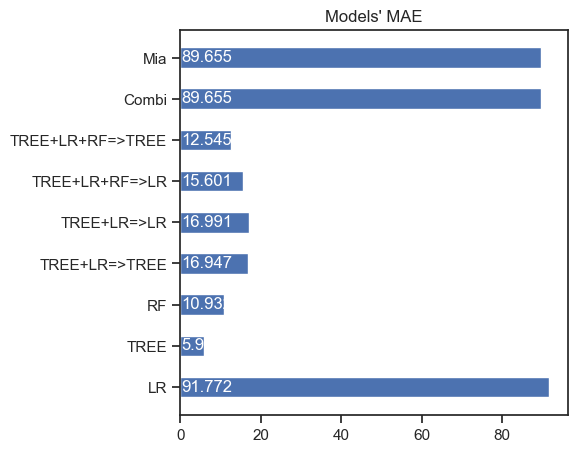

In [45]:
dict_mae = {
            'LR': 91.77213251714615,
            'TREE': 5.932203389830509,
            'RF': 10.932203389830509,
            'TREE+LR=>TREE': 16.947463768115945,
            'TREE+LR=>LR': 16.991272889514768,
            'TREE+LR+RF=>LR': 15.601464066506784,
            'TREE+LR+RF=>TREE': 12.545289855072465,
            'Combi': 89.65482934967766,
            'Mia': 89.65482934967766,
            }
vis_models_quality(list(dict_mae.values()), list(dict_mae.keys()), 'Models\' MAE')